# Fold, train-test, sequence creation. Baseline, Simple RNN, LSTM modelling.

In [69]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Import data

In [70]:
FILE = '../../db/data/merge/volatility/volatility.csv'
df = pd.read_csv(FILE, index_col=0)
df.index = pd.to_datetime(df.index)
display(df.head(3))
display(df.tail(3))

,AUD_CAD,AUD_CHF,AUD_JPY,AUD_NZD,AUD_USD,CAD_CHF,CAD_JPY,CHF_JPY,EUR_AUD,EUR_CAD,...,USD_CHF_corr,USD_JPY_corr,month_sin,month_cos,day_sin,day_cos,weekday_sin,weekday_cos,hour_sin,hour_cos
2005-01-03 00:00:00+00:00,-0.056357,0.044868,-0.236804,-0.027523,-0.191681,0.090711,-0.187507,-0.277763,-0.046156,-0.119630,...,NaN,NaN,0.5,0.866025,0.052336,0.99863,0.0,1.0,0.000000,1.000000
2005-01-03 01:00:00+00:00,0.057418,0.116563,-0.162348,-0.068844,-0.031983,0.047432,-0.211379,-0.267380,-0.023087,0.033756,...,NaN,NaN,0.5,0.866025,0.052336,0.99863,0.0,1.0,0.258819,0.965926
2005-01-03 02:00:00+00:00,-0.206473,0.062703,-0.262812,-0.018366,-0.243434,0.294601,-0.058796,-0.346427,0.000000,-0.215034,...,NaN,NaN,0.5,0.866025,0.052336,0.99863,0.0,1.0,0.500000,0.866025


,AUD_CAD,AUD_CHF,AUD_JPY,AUD_NZD,AUD_USD,CAD_CHF,CAD_JPY,CHF_JPY,EUR_AUD,EUR_CAD,...,USD_CHF_corr,USD_JPY_corr,month_sin,month_cos,day_sin,day_cos,weekday_sin,weekday_cos,hour_sin,hour_cos
2022-12-27 21:00:00+00:00,-0.007845,0.06606,0.029396,0.028726,0.045747,0.073684,0.035599,-0.038459,-0.010937,-0.016088,...,-0.036953,NaN,-2.449294e-16,1.0,0.017452,0.999848,0.781831,0.62349,-0.707107,0.707107
2022-12-27 22:00:00+00:00,-0.007845,0.06606,0.029396,0.028726,0.045747,0.073684,0.035599,-0.038459,-0.010937,-0.016088,...,-0.036953,NaN,-2.449294e-16,1.0,0.017452,0.999848,0.781831,0.62349,-0.500000,0.866025
2022-12-27 23:00:00+00:00,-0.007845,0.06606,0.029396,0.028726,0.045747,0.073684,0.035599,-0.038459,-0.010937,-0.016088,...,-0.033874,NaN,-2.449294e-16,1.0,0.017452,0.999848,0.781831,0.62349,-0.258819,0.965926


In [71]:
df.shape

(111096, 104)

## Filter desired columns (optional)

In [72]:
df.columns[:28]

Index(['AUD_CAD', 'AUD_CHF', 'AUD_JPY', 'AUD_NZD', 'AUD_USD', 'CAD_CHF',
       'CAD_JPY', 'CHF_JPY', 'EUR_AUD', 'EUR_CAD', 'EUR_CHF', 'EUR_GBP',
       'EUR_JPY', 'EUR_NZD', 'EUR_USD', 'GBP_AUD', 'GBP_CAD', 'GBP_CHF',
       'GBP_JPY', 'GBP_NZD', 'GBP_USD', 'NZD_CAD', 'NZD_CHF', 'NZD_JPY',
       'NZD_USD', 'USD_CAD', 'USD_CHF', 'USD_JPY'],
      dtype='object')

`Choose one pair from above and set it to TARGET_PAIR`

In [73]:
TARGET_PAIR = 'AUD_CAD'
display(df[TARGET_PAIR].describe().loc[['count', 'min', 'mean', '50%', 'max']].to_frame())
df.shape

,AUD_CAD
count,111096.000000
min,-4.217846
mean,-0.000748
50%,-0.000944
max,2.828063


(111096, 104)

In [74]:
first, second = TARGET_PAIR.split('_')
index = [col for col in df.columns[28:] if (first in col or second in col) and '_corr' not in col]
index.insert(0, TARGET_PAIR)
index.append(f'{TARGET_PAIR}_corr')
index += df.columns[-8:].to_list()
pair_df = df[index]
display(pair_df.head(3), pair_df.tail(3))

,AUD_CAD,AUD_sma,AUD_std,CAD_sma,CAD_std,high_AUD,low_AUD,atr_AUD,high_CAD,low_CAD,atr_CAD,AUD_CAD_corr,month_sin,month_cos,day_sin,day_cos,weekday_sin,weekday_cos,hour_sin,hour_cos
2005-01-03 00:00:00+00:00,-0.056357,NaN,NaN,NaN,NaN,0.121767,0.069635,0.052132,0.093836,0.087292,0.006544,NaN,0.5,0.866025,0.052336,0.99863,0.0,1.0,0.000000,1.000000
2005-01-03 01:00:00+00:00,0.057418,NaN,NaN,NaN,NaN,0.108162,0.071188,7.186180,0.108821,0.082313,7.143055,NaN,0.5,0.866025,0.052336,0.99863,0.0,1.0,0.258819,0.965926
2005-01-03 02:00:00+00:00,-0.206473,NaN,NaN,NaN,NaN,0.151917,0.046523,13.811973,0.131936,0.063988,13.766291,NaN,0.5,0.866025,0.052336,0.99863,0.0,1.0,0.500000,0.866025


,AUD_CAD,AUD_sma,AUD_std,CAD_sma,CAD_std,high_AUD,low_AUD,atr_AUD,high_CAD,low_CAD,atr_CAD,AUD_CAD_corr,month_sin,month_cos,day_sin,day_cos,weekday_sin,weekday_cos,hour_sin,hour_cos
2022-12-27 21:00:00+00:00,-0.007845,0.02303,1.812023e-08,0.027319,2.103222e-08,0.014231,0.043273,160.662114,0.027374,0.037034,177.053546,-0.017568,-2.449294e-16,1.0,0.017452,0.999848,0.781831,0.62349,-0.707107,0.707107
2022-12-27 22:00:00+00:00,-0.007845,0.02303,1.812023e-08,0.027319,2.103222e-08,0.014231,0.043273,160.699125,0.027374,0.037034,177.101925,-0.017568,-2.449294e-16,1.0,0.017452,0.999848,0.781831,0.62349,-0.500000,0.866025
2022-12-27 23:00:00+00:00,-0.007845,0.02303,1.812023e-08,0.027319,2.103222e-08,0.014231,0.043273,160.736144,0.027374,0.037034,177.150318,-0.016732,-2.449294e-16,1.0,0.017452,0.999848,0.781831,0.62349,-0.258819,0.965926


## Clean unknown data

In [77]:
from datetime import datetime, timedelta
from pytz import UTC

In [78]:
LAST_VALID_DAY = datetime(2022, 8, 31, 9, 0, 0, 0, UTC)
FIRST_VALID_DAY = LAST_VALID_DAY - timedelta(days = 10 * ( 365.25 )) # Last 10 years
clean_df = pair_df.loc[FIRST_VALID_DAY:LAST_VALID_DAY]
display(clean_df.head(3), clean_df.tail(3))
clean_df.shape

,AUD_CAD,AUD_sma,AUD_std,CAD_sma,CAD_std,high_AUD,low_AUD,atr_AUD,high_CAD,low_CAD,atr_CAD,AUD_CAD_corr,month_sin,month_cos,day_sin,day_cos,weekday_sin,weekday_cos,hour_sin,hour_cos
2012-08-30 21:00:00+00:00,0.038183,-0.006027,0.046314,-0.001009,0.037207,0.049074,0.056845,101.442163,0.034340,0.043699,100.910605,-0.035947,-0.866025,-0.5,-0.891007,-0.45399,0.433884,-0.900969,-0.707107,0.707107
2012-08-30 22:00:00+00:00,0.011746,-0.006855,0.046102,-0.001675,0.037397,0.025161,0.035516,101.433978,0.026420,0.025477,100.912727,-0.033191,-0.866025,-0.5,-0.891007,-0.45399,0.433884,-0.900969,-0.500000,0.866025
2012-08-30 23:00:00+00:00,-0.104784,-0.009920,0.048352,-0.001127,0.037100,0.091544,0.047012,101.423751,0.046115,0.035406,100.911989,-0.026990,-0.866025,-0.5,-0.891007,-0.45399,0.433884,-0.900969,-0.258819,0.965926


,AUD_CAD,AUD_sma,AUD_std,CAD_sma,CAD_std,high_AUD,low_AUD,atr_AUD,high_CAD,low_CAD,atr_CAD,AUD_CAD_corr,month_sin,month_cos,day_sin,day_cos,weekday_sin,weekday_cos,hour_sin,hour_cos
2022-08-31 07:00:00+00:00,-0.055507,0.006455,0.094999,-0.004175,0.052639,0.099357,0.058363,102.983455,0.072908,0.075072,103.808523,0.123905,-0.866025,-0.5,-0.891007,-0.45399,0.974928,-0.222521,0.965926,-0.258819
2022-08-31 08:00:00+00:00,0.008884,0.006440,0.095006,-0.004734,0.052898,0.137844,0.050284,102.993607,0.112465,0.070695,103.804057,0.132378,-0.866025,-0.5,-0.891007,-0.45399,0.974928,-0.222521,0.866025,-0.500000
2022-08-31 09:00:00+00:00,-0.191175,0.003213,0.097390,-0.001913,0.052018,0.118359,0.064150,102.999068,0.085164,0.062074,103.797426,0.105726,-0.866025,-0.5,-0.891007,-0.45399,0.974928,-0.222521,0.707107,-0.707107


(61693, 20)

## Drop NaN and outliers

In [79]:
clean_df = clean_df.dropna()
clean_df.shape

(61693, 20)

## Scale

In [89]:
from sklearn.preprocessing import StandardScaler

In [90]:
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(clean_df), columns=clean_df.columns, index=clean_df.index)
display(df_scaled.describe().loc[['count', 'min', 'mean', '50%', 'max']])
df_scaled.shape

,AUD_CAD,AUD_sma,AUD_std,CAD_sma,CAD_std,high_AUD,low_AUD,atr_AUD,high_CAD,low_CAD,atr_CAD,AUD_CAD_corr,month_sin,month_cos,day_sin,day_cos,weekday_sin,weekday_cos,hour_sin,hour_cos
count,6.169300e+04,6.169300e+04,6.169300e+04,6.169300e+04,6.169300e+04,6.169300e+04,6.169300e+04,6.169300e+04,6.169300e+04,6.169300e+04,6.169300e+04,6.169300e+04,6.169300e+04,6.169300e+04,6.169300e+04,6.169300e+04,6.169300e+04,6.169300e+04,6.169300e+04,6.169300e+04
min,-3.937990e+01,-8.675338e+00,-1.690223e+00,-9.898288e+00,-1.981202e+00,-1.357151e+00,-1.446798e+00,-3.729895e+00,-1.453044e+00,-1.490587e+00,-3.561115e+00,-2.647146e+00,-1.398353e+00,-1.397821e+00,-1.414642e+00,-1.414242e+00,-1.526454e+00,-1.053606e+00,-1.414337e+00,-1.414337e+00
mean,1.212206e-17,6.449742e-18,-3.114304e-16,1.566366e-17,3.022165e-16,-1.382088e-17,2.598325e-16,-1.400515e-15,-1.345232e-16,3.501289e-17,-7.887113e-16,9.582474e-17,7.739690e-17,4.791237e-17,-3.685567e-18,1.842783e-17,1.371722e-16,-1.072270e-16,2.951333e-17,-8.234938e-18
50%,2.792878e-03,4.281020e-02,-2.192778e-01,2.104823e-02,-2.097873e-01,-2.259372e-01,-2.276713e-01,1.125717e-01,-2.360705e-01,-2.320491e-01,-9.838414e-02,-7.247602e-02,9.429501e-03,2.336513e-02,-3.477398e-04,-1.088828e-04,1.612279e-01,-1.820047e-01,-1.231218e-04,-1.231218e-04
max,1.870051e+01,5.901379e+00,1.364183e+01,5.768731e+00,7.762233e+00,5.869579e+01,3.845511e+01,2.787260e+00,3.713470e+01,2.614710e+01,2.782515e+00,4.338032e+00,1.417212e+00,1.444551e+00,1.413947e+00,1.414024e+00,1.213480e+00,1.388566e+00,1.414090e+00,1.414090e+00


(61693, 20)

## Split train, val and test data

In [91]:
TEST_RATIO = 0.05
INPUT_LENGTH = 1 * 21 * 24 # 1 month sequence size

In [92]:
test_len = round(len(df_scaled) * TEST_RATIO)

df_train = df_scaled.iloc[:-test_len]
df_test = df_scaled.iloc[-test_len - INPUT_LENGTH:]

display(df_train.tail(3), df_test.head(3))
df_train.shape, df_test.shape

,AUD_CAD,AUD_sma,AUD_std,CAD_sma,CAD_std,high_AUD,low_AUD,atr_AUD,high_CAD,low_CAD,atr_CAD,AUD_CAD_corr,month_sin,month_cos,day_sin,day_cos,weekday_sin,weekday_cos,hour_sin,hour_cos
2022-03-03 18:00:00+00:00,1.581502,1.703957,-0.232985,0.585584,-0.662329,-0.589221,0.604092,0.473754,-0.456030,0.662119,-0.025340,0.416556,1.417212,0.023365,1.2484,0.663786,0.161228,-1.053606,-1.414337,-0.000123
2022-03-03 19:00:00+00:00,-0.278556,1.681065,-0.227458,0.592476,-0.663134,0.207690,-0.686646,0.481990,0.012054,-0.411858,-0.030199,0.362796,1.417212,0.023365,1.2484,0.663786,0.161228,-1.053606,-1.366149,0.365902
2022-03-03 20:00:00+00:00,-0.168071,1.617331,-0.222265,0.693756,-0.688988,-0.706899,-0.150597,0.488935,-0.400294,-0.483226,-0.034775,0.412177,1.417212,0.023365,1.2484,0.663786,0.161228,-1.053606,-1.224868,0.706984


,AUD_CAD,AUD_sma,AUD_std,CAD_sma,CAD_std,high_AUD,low_AUD,atr_AUD,high_CAD,low_CAD,atr_CAD,AUD_CAD_corr,month_sin,month_cos,day_sin,day_cos,weekday_sin,weekday_cos,hour_sin,hour_cos
2022-02-02 21:00:00+00:00,-0.461894,0.632310,0.614476,-0.664170,-0.007135,-0.547793,-0.558545,-0.238422,-0.353508,-0.886693,-0.077597,0.346246,1.228605,0.733958,0.769932,1.185883,1.21348,-0.182005,-1.000123,0.999877
2022-02-02 22:00:00+00:00,-0.183064,0.623398,0.614981,-0.665422,-0.007076,-0.814917,-0.370352,-0.237780,-0.579352,-0.824253,-0.076617,0.348384,1.228605,0.733958,0.769932,1.185883,1.21348,-0.182005,-0.707230,1.224622
2022-02-02 23:00:00+00:00,-0.792690,0.357402,0.649703,-0.587669,-0.024972,0.465245,-0.087499,-0.238305,0.345441,-0.444918,-0.076395,0.352726,1.228605,0.733958,0.769932,1.185883,1.21348,-0.182005,-0.366149,1.365902


((58608, 20), (3589, 20))

## Create sequences train and validation

In [93]:
OUTPUT_LENGTH = 1 # Number of values to predict
SEQUENCE_STRIDE = 24 # Gap between sequences

### Get chronological X, y (Option 1)

In [94]:
def get_X_y_strides(fold: pd.DataFrame,
                    input_length: int,
                    output_length: int,
                    stride: int):
    '''
    - slides through a `fold` Time Series (2D array) to create sequences of equal
        * `input_length` for X,
        * `output_length` for y,
    using a temporal gap `sequence_stride` between each sequence
    - returns a list of sequences, each as a 2D-array time series
    '''
    X, y = [], []
    
    for i in range(len(fold), 0, -stride):
        if i - input_length - output_length < 0:
            break
        X_i = fold.iloc[i - input_length - output_length: i - output_length]
        y_i = fold.iloc[i - output_length: i][TARGET_PAIR]
        X.insert(0, X_i)
        y.insert(0, y_i)
        
    return np.array(X), np.array(y)

In [97]:
# X_train_chr, y_train_chr = get_X_y_strides(df_train, INPUT_LENGTH, OUTPUT_LENGTH, SEQUENCE_STRIDE)
X_test, y_test = get_X_y_strides(df_test, INPUT_LENGTH, OUTPUT_LENGTH, 1)

# X_train_chr.shape, y_train_chr.shape
X_test.shape, y_test.shape

((3085, 504, 20), (3085, 1))

#### Get random n sequences (Option 2) 

In [98]:
def get_Xi_yi(fold:pd.DataFrame, 
              input_length:int, 
              output_length:int):
    '''
    - given a fold, it returns one sequence (X_i, y_i)
    - with the starting point of the sequence being chosen at random
    '''
    
    first_possible_start = 0
    last_possible_start = len(fold) - input_length - output_length + 1
    start = np.random.randint(first_possible_start, last_possible_start)
    X_i = fold.iloc[start:start+input_length]    
    y_i = fold.iloc[start+input_length:
                  start+input_length+output_length][TARGET_PAIR]
    
    return X_i, y_i

In [99]:
def get_X_y(fold:pd.DataFrame,
            number_of_sequences:int,
            input_length:int,
            output_length:int):
        
    X, y = [], []

    for i in range(number_of_sequences):
        Xi, yi = get_Xi_yi(fold, input_length, output_length)
        X.append(Xi)
        y.append(yi)
        
    return np.array(X), np.array(y)

In [100]:
N_TRAIN_SEQ = 5000
# N_TEST_SEQ = 500

In [101]:
X_train, y_train = get_X_y(df_train, N_TRAIN_SEQ, INPUT_LENGTH, OUTPUT_LENGTH)

X_train.shape, y_train.shape

((5000, 504, 20), (5000, 1))

## Modelling

In [103]:
from typing import Union
from keras.api._v2.keras import Model
from keras.api._v2.keras.optimizers import Optimizer, Adam
from keras.api._v2.keras.models import Sequential
from keras.api._v2.keras.layers import Dense, SimpleRNN, Dropout, LSTM, Lambda, Bidirectional
from keras.api._v2.keras.callbacks import EarlyStopping
from keras.api._v2.keras.layers.experimental.preprocessing import Normalization

### Create baseline model

It will predict the last log return, no need to `fit` it as it has no params.

In [104]:
def init_baseline():

    model = Sequential()
    model.add(Lambda(lambda x: x[:, -1, 0]))

    return model

### Create simple RNN model

In [117]:
def init_srnn_model(X_train, y_train):
    
    regressor = Sequential()

    regressor.add(SimpleRNN(32, return_sequences=True, input_shape=X_train[0].shape))
    regressor.add(Dropout(0.2))

    regressor.add(SimpleRNN(32, return_sequences=True))
    regressor.add(Dropout(0.2))

    regressor.add(SimpleRNN(32))
    regressor.add(Dropout(0.2))

    regressor.add(Dense(16))

    regressor.add(Dense(y_train.shape[1], activation="linear"))
    
    return regressor

### Create LSTM model

In [118]:
def init_lstm_model(X_train, y_train):
        
    lstm = Sequential()
    
    lstm.add(LSTM(32, return_sequences=True, recurrent_dropout=0.2, input_shape=X_train.shape[1:]))
    lstm.add(LSTM(32, return_sequences=True, recurrent_dropout=0.2))
    lstm.add(LSTM(32, return_sequences=False, recurrent_dropout=0.2))
    lstm.add(Dense(8))
    
    lstm.add(Dense(y_train.shape[1], activation='linear'))
    
    return lstm

### Create compile and fit functions

In [126]:
def compile_model(model: Model,
                  optimizer:Union[str, Optimizer]='adam',
                  loss='mse',
                  metrics:list=['mae']):
    
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    return model

In [127]:
def fit_model(model: Model,
              X, y,
              # X_val, y_val,
              epochs:int=20,
              batch_size:int=16,
              verbose:int=1):
    
    es = EarlyStopping(patience=2,
                       mode="min",
                       restore_best_weights=True)

    history = model.fit(X, y,
                        epochs=epochs,
                        batch_size=batch_size,
                        # validation_data=(X_val, y_val),
                        validation_split=0.2,
                        callbacks=[es])
    
    return model, history

### MLFlow autolog

In [121]:
import mlflow
import mlflow.tensorflow

In [122]:
mlflow.set_tracking_uri("https://mlflow.lewagon.ai")
mlflow.set_experiment(experiment_name="rex-ai")
mlflow.tensorflow.autolog()

### Initialise, compile and train the models

#### Baseline Chronological sequences

In [123]:
baseline = init_baseline()
baseline = compile_model(baseline)
baseline_score = baseline.evaluate(X_test, y_test)

print(f"- The Baseline MAE on the test set is equal to {round(baseline_score[1],6)} log return")

97/97 [==============================] - 0s 1ms/step - loss: 2.1363 - mae: 1.0682 - mape: 580.0437
- The Baseline MAE on the test set is equal to 1.068199 log return


#### Simple RNN Chronological Sequences

`We stop using Chronological sequences for training as they get worse results than random`

In [128]:
# srnn_chr = init_srnn_model(X_train_chr, y_train_chr)
# srnn_chr = compile_model(srnn_chr)
# srnn_chr, history_srnn_chr = fit_model(srnn_chr, X_train_chr, y_train_chr)
# srnn_chr_score = srnn_chr.evaluate(X_test, y_test)

# print(f"- The Simple RNN MAE on the test set is equal to {round(srnn_chr_score[1],6)} log return")

#### Simple RNN Random Sequences

In [125]:
srnn = init_srnn_model(X_train, y_train)
srnn = compile_model(srnn)
srnn, history_srnn = fit_model(srnn, X_train, y_train)
srnn_score = srnn.evaluate(X_test, y_test)

print(f"- The Simple RNN MAE on the test set is equal to {round(srnn_score[1],6)} log return")

2022/09/06 10:43:21 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'fada849e7d284ab88893b336961beef6', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/20
250/250 [==============================] - 88s 346ms/step - loss: 1.1916 - mae: 0.7902 - mape: 356.0181 - val_loss: 1.1167 - val_mae: 0.7120 - val_mape: 192.2073
Epoch 2/20
250/250 [==============================] - 84s 338ms/step - loss: 0.9330 - mae: 0.6734 - mape: 207.2252 - val_loss: 1.0912 - val_mae: 0.6960 - val_mape: 159.1193
Epoch 3/20
250/250 [==============================] - 94s 375ms/step - loss: 0.9209 - mae: 0.6674 - mape: 162.9290 - val_loss: 1.0766 - val_mae: 0.6901 - val_mape: 134.6585
Epoch 4/20
250/250 [==============================] - 91s 363ms/step - loss: 0.9176 - mae: 0.6643 - mape: 157.8304 - val_loss: 1.1145 - val_mae: 0.7129 - val_mape: 211.7161
Epoch 5/20
250/250 [==============================] - 91s 364ms/step - loss: 0.9134 - mae: 0.6610 - mape: 158.1701 - val_loss: 1.0965 - val_mae: 0.6985 - val_mape: 156.1168
INFO:tensorflow:Assets written to: /tmp/tmpq4f08hqs/model/data/model/assets
97/97 [==============================] - 10s 107ms/step - l

#### LSTM Chronological Sequences

`We stop using Chronological sequences for training as they get worse results than random`

In [129]:
# lstm_chr = init_lstm_model(X_train_chr, y_train_chr)
# lstm_chr = compile_model(lstm_chr)
# lstm_chr, history_lstm_chr = fit_model(lstm_chr, X_train_chr, y_train_chr)
# lstm_chr_score = lstm_chr.evaluate(X_test, y_test)

# print(f"- The LSTM MAE on the test set is equal to {round(lstm_chr_score[1],6)} log return")

#### LSTM Random Sequences

In [ ]:
lstm = init_lstm_model(X_train, y_train)
lstm = compile_model(lstm)
lstm, history = fit_model(lstm, X_train, y_train)
lstm_score = lstm.evaluate(X_test, y_test)

print(f"- The LSTM MAE on the test set is equal to {round(lstm_score[1],6)} log return")

## Save model MLFlow

In [43]:
import mlflow

In [44]:
mlflow.set_tracking_uri("https://mlflow.lewagon.ai")
mlflow.set_experiment(experiment_name="rex-ai")

names = ['baseline', f'srnn_{TARGET_PAIR}', f'lstm_{TARGET_PAIR}']
models = [ baseline, srnn, lstm]
scores = [ baseline_score, srnn_score, lstm_score]

for name, model, score in zip(names, models, scores):
    with mlflow.start_run():

        params = dict(batch_size=16, row_count=df_train.shape[0])
        metrics = dict(mae=score[0])

        mlflow.log_params(params)
        mlflow.log_metrics(metrics)  # type: ignore

        mlflow.keras.log_model(keras_model=model,
                            artifact_path="model",
                            keras_module="tensorflow.keras",
                            registered_model_name=name)

INFO:tensorflow:Assets written to: /tmp/tmppplvdj2w/model/data/model/assets


Registered model 'baseline' already exists. Creating a new version of this model...
2022/09/06 09:51:17 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: baseline, version 3
Created version '3' of model 'baseline'.


INFO:tensorflow:Assets written to: /tmp/tmp53tkpq90/model/data/model/assets


Registered model 'srnn_chr' already exists. Creating a new version of this model...
2022/09/06 09:51:25 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: srnn_chr, version 2
Created version '2' of model 'srnn_chr'.


INFO:tensorflow:Assets written to: /tmp/tmpw0xbstqo/model/data/model/assets


Registered model 'srnn_rnd' already exists. Creating a new version of this model...
2022/09/06 09:51:34 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: srnn_rnd, version 3
Created version '3' of model 'srnn_rnd'.


INFO:tensorflow:Assets written to: /tmp/tmpcdenc5vy/model/data/model/assets


Registered model 'lstm_chr' already exists. Creating a new version of this model...
2022/09/06 09:51:47 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: lstm_chr, version 2
Created version '2' of model 'lstm_chr'.


INFO:tensorflow:Assets written to: /tmp/tmpvn2r7jny/model/data/model/assets


Registered model 'lstm_rnd' already exists. Creating a new version of this model...
2022/09/06 09:52:03 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: lstm_rnd, version 4
Created version '4' of model 'lstm_rnd'.


## Make predictions and plot

In [45]:
y_pred_baseline = baseline.predict(X_test)
y_pred_srnn_rnd = srnn_rnd.predict(X_test)
y_pred_lstm_rnd = lstm_rnd.predict(X_test)

y_pred_baseline.shape, y_pred_srnn_rnd.shape, y_pred_lstm_rnd.shape

97/97 [==============================] - 25s 251ms/step


((3085, 28), (3085, 28), (3085, 28), (3085, 28), (3085, 28))

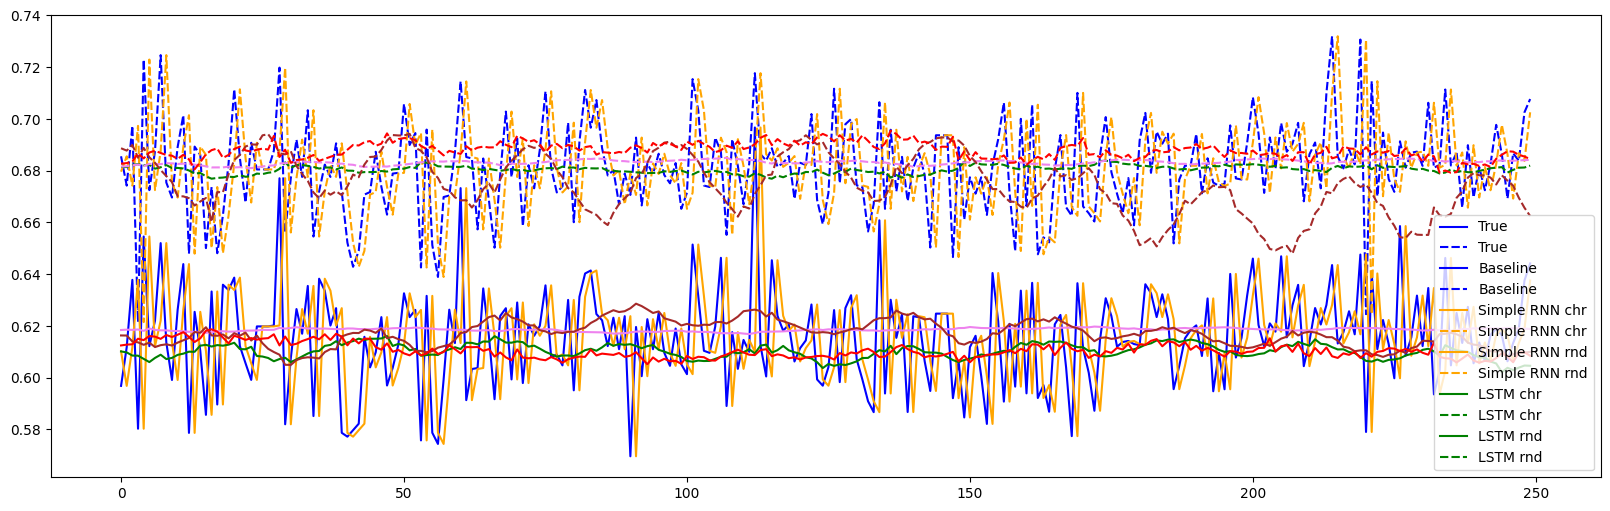

In [57]:
fig = plt.figure(figsize=(20,6))
sns.lineplot(data=y_test.reshape(3085,28)[:250, 1:3], palette=['b', 'b'])
sns.lineplot(data=y_pred_baseline[:250, 1:3], palette=['orange', 'orange'])
# sns.lineplot(data=y_pred_srnn_chr[:250, 1:3], palette=['g', 'g'])
sns.lineplot(data=y_pred_srnn_rnd[:250, 1:3], palette=['violet', 'violet'])
# sns.lineplot(data=y_pred_lstm_chr[:250, 1:3], palette=['brown', 'brown'])
sns.lineplot(data=y_pred_lstm_rnd[:250, 1:3], palette=['r', 'r'])
plt.legend(labels=["True","True","Baseline","Baseline", 'Simple RNN chr','Simple RNN chr', 'Simple RNN rnd','Simple RNN rnd', 'LSTM chr', 'LSTM chr', 'LSTM rnd','LSTM rnd']);